In [ ]:
try:
     from dlroms import*
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

## **Lab 2 - Deep Operator Networks (DeepONets)**

Deep Operator Networks (DeepONets) aim to approximate function-to-function maps, that is, correspondences of the form $f \mapsto u$.

To understand the idea, however, it is easier to start from the special case in which the input is actually finite dimensional, meaning that the operator of interest is of the form

$$\boldsymbol{\mu}\mapsto u_{\boldsymbol{\mu}},$$

where a finite-dimensional vector of input parameters, $\boldsymbol{\mu}$, is mapped onto some function $u_{\boldsymbol{\mu}}:\Omega\to\mathbb{R}$ defined on a suitable spatial domain $\Omega\subset\mathbb{R}^{2}$. We can think, for instance, as $\boldsymbol{\mu}$ being the parameters of a PDE and $u_{\boldsymbol{\mu}}$ as its corresponding solution.

Essentially, the idea of DeepONets is to approximate this map by directly prescribing the parametrized output $u=u(\boldsymbol{\mu},\boldsymbol{x})$ through a separation of variables approach. That is, for every $\boldsymbol{\mu}$ in the parameter space and every $\boldsymbol{x}$ in the spatial domain, one writes

$$u_{\boldsymbol{\mu}}(\boldsymbol{x})=u(\boldsymbol{\mu},\boldsymbol{x})\approx \sum_{i=1}^{m}\xi_i(\boldsymbol{x})\phi_i(\boldsymbol{\mu}),$$

and proceeds by learning the maps $\xi_1,\dots,\xi_m$ and $\phi_1,\dots,\phi_m$ through neural networks. In practice, this is typically implemented using two multi-valued networks rather than $m$ pairs of independent architectures. That is, having fixed $m\in\mathbb{N}$, one seeks for

$$\xi:\mathbb{R}^{d}\to\mathbb{R}^{m}\quad\text{and}\quad\phi:\mathbb{R}^{p}\to\mathbb{R}^{m}$$

such that

$$u_{\boldsymbol{\mu}}(\boldsymbol{x})=u(\boldsymbol{\mu},\boldsymbol{x})\approx \xi(\boldsymbol{x})\cdot\phi(\boldsymbol{\mu}),$$

with "$\cdot$" being the scalar product. The networks $\xi$ and $\phi$ are commonly referred to as the *trunk* and *branch*, respectively.
</br>
</br>

When it comes to DeepONets, the training phase is typically supervised, meaning that for several $\boldsymbol{\mu}_{1},\dots,\boldsymbol{\mu}_{N}$ we have the ground truth output $u_{\boldsymbol{\mu}_i}$ available as a reference. However, the idea can be easily integrated within the framework of physics-informed machine learning by leveraging automatic differentiation and PDE-based losses.</br></br>
_______________________________________
</br>

So what about the original "function-to-function" case? Assume that the input of the model is supposed to be a function on some other domain, $f:\Omega'\to\mathbb{R}$. We start by choosing a number of sensors $p\in\mathbb{N}$ and fixing a suitable collection of points $\boldsymbol{y}_1,\dots,\boldsymbol{y}_p\in\Omega'$. Then, we identity $f$ with

$$\boldsymbol{\mu}:=[f(\boldsymbol{y}_1),\dots,f(\boldsymbol{y}_p)]^\top\in\mathbb{R}^{p}.$$

Then, we just forget about $f$ and instead work directly with $\boldsymbol{\mu}$!

## Implementation (from scratch)

Below is an implementation of DeepONets using the $\textsf{dlroms}$ library.

In [ ]:
class DeepONet(ROM):

  def __init__(self, branch, trunk):
    super(DeepONet, self).__init__(branch, trunk)
    self.branch = branch
    self.trunk = trunk

  def forward(self, mu, x):
    return (self.branch(mu)*self.trunk(x)).sum(axis = -1)

When the solution is sought (and provided during training) over a fixed mesh/grid, an equivalent formulation (but also more handy) can be the following.

In [ ]:
class DeepONetX(ROM):

  def __init__(self, branch, trunk, x):
    super(DeepONetX, self).__init__(branch, trunk)
    self.branch = branch
    self.trunk = trunk
    self.x = x

  def forward(self, mu):
    return self.branch(mu) @ self.trunk(self.x).T

## Finite-dimensional example

Let us consider the following example, arising from a parametrized partial differential equation. Specifically, we consider the following Poisson equation

$$\begin{cases}
-\sigma\Delta u(\boldsymbol{x}) = \gamma\sin(4x_1x_2) + (1-\gamma)\cos(x_1-8x_2) & \boldsymbol{x}\in\Omega\\\\
u(\boldsymbol{x})= b & \boldsymbol{x}\in\Gamma\\\\
-\nabla u(\boldsymbol{x})\cdot \boldsymbol{n}=0 & \boldsymbol{x}\in\partial\Omega\setminus\Gamma
\end{cases}$$
$$$$

where $\Omega=(0,1)^2$ is the unit square and $\Gamma=\{(0,x_2)\;:\;0\le x_2\le1\}$ is the left edge. The PDE parameters are $\boldsymbol{\mu}=[\sigma,b,\gamma]$, with $\sigma\in[0.1,1]$, $b\in[0,2]$ and $\gamma\in[0,1]$. In particular, $p=3$.

</br>
</br>

To boost things up, a set of PDE solutions has already been computed and is available via the following lines of code.

In [ ]:
import gdown
import numpy as np

gdown.download(id = "1c9jCfgzie74vfhVgZueKySIZv9AHXng_", output = "poisson_data.npz")
dataset = np.load("poisson_data.npz")
mu, u = dataset['mu'], dataset['u']

Downloading...
From: https://drive.google.com/uc?id=1c9jCfgzie74vfhVgZueKySIZv9AHXng_
To: /content/poisson_data.npz
100%|██████████| 6.74M/6.74M [00:00<00:00, 25.5MB/s]


In [ ]:
mu.shape, u.shape

((500, 3), (500, 1681))

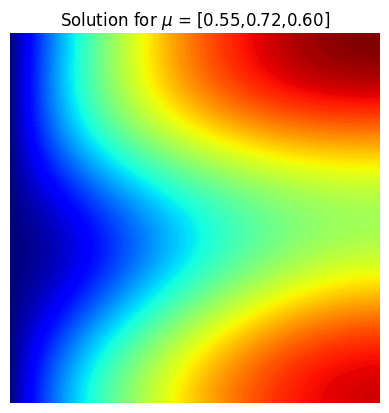

In [ ]:
from IPython.display import clear_output as clc
import matplotlib.pyplot as plt
mesh = fe.unitsquaremesh(40, 40)
Vh = fe.space(mesh, 'CG', 1)
clc()

fe.plot(u[1], Vh)
plt.title("Solution for $\mu$ = [%.2f,%.2f,%.2f]" % tuple(mu[0]))
None

In [ ]:
x = fe.coordinates(Vh)
x

array([[0.   , 1.   ],
       [0.   , 0.975],
       [0.025, 1.   ],
       ...,
       [0.975, 0.   ],
       [1.   , 0.025],
       [1.   , 0.   ]], dtype=float32)

In [ ]:
mu, u, x = dv.tensor(mu, u, x)

In [ ]:
p, d = mu.shape[1], x.shape[1]
m = 15

branch = Dense(p, 40) + Dense(40, 40) + Dense(40, m, activation = None)
trunk  = Dense(d, 40) + Dense(40, 40) + Dense(40, m, activation = None)

model = DeepONetX(branch, trunk, x)
model.He()

In [ ]:
ntrain = 400
def loss(true, predicted):
  return (true-predicted).pow(2).mean(axis = -1).mean()

def error(true, predicted):
  return ((true-predicted).abs().mean(axis = -1)/true.abs().mean(axis = -1)).mean()

model.train(mu, u, epochs = 50, ntrain = ntrain, nvalid = 100, loss = loss, error = error, notation = '%')

		Train	Valid	Test
Epoch 50:	0.72%	0.92%	0.69%.

>> ETA: 0.27s.

Training complete. Elapsed time: 13.25 seconds.


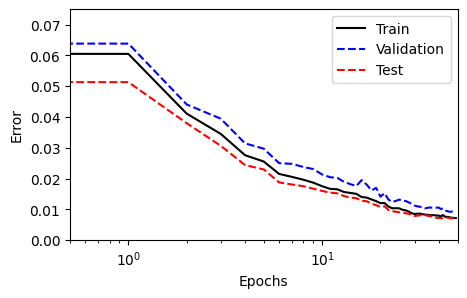

In [ ]:
n_epochs = len(model.errors['Train'])
plt.figure(figsize = (5, 3))
plt.semilogx(model.errors['Train'], '-k', label = 'Train')
plt.semilogx(model.errors['Validation'], '--b', label = 'Validation')
plt.semilogx(model.errors['Test'], '--r', label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.axis([0.5, n_epochs, 0, 0.075])
plt.legend()
plt.show()

In [ ]:
model.freeze()

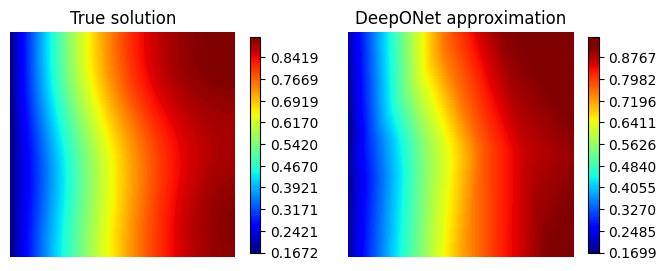

In [ ]:
j = -2
plt.figure(figsize = (8, 4))
vmin, vmax = u[j].min(), u[j].max()

plt.subplot(1,2,1)
plt.title("True solution")
fe.plot(u[j], Vh, colorbar = True, vmin = vmin, vmax = vmax, shrink = 0.7)

plt.subplot(1,2,2)
plt.title("DeepONet approximation")
fe.plot(model(mu[j]), Vh, colorbar = True, vmin = vmin, vmax = vmax, shrink = 0.7)

## Function-to-function example

Let us consider the following example. We would like to learn a nonlinear operator $G$ mapping 1D functions onto 1D functions acting as

$$G:\quad f(y)\mapsto \int_{0}^{x}\frac{1}{1+f(2s)^2}ds,$$

where $f=f(y)$ is defined for $y\in[0,1]$, whereas the output $u=u(x)$ is defined for $x\in[0,1/2]$.

The following lines of code provide an implementation of such operator in $\textsf{scipy}$.

In [ ]:
from scipy.integrate import quad

def G(f):
  integrand = lambda s: 1.0/(1.0 + f(2*s)**2)
  return lambda x: quad(integrand, 0, x)[0]

In [ ]:
f = lambda y: np.sin(2*np.pi*y)
u = G(f)

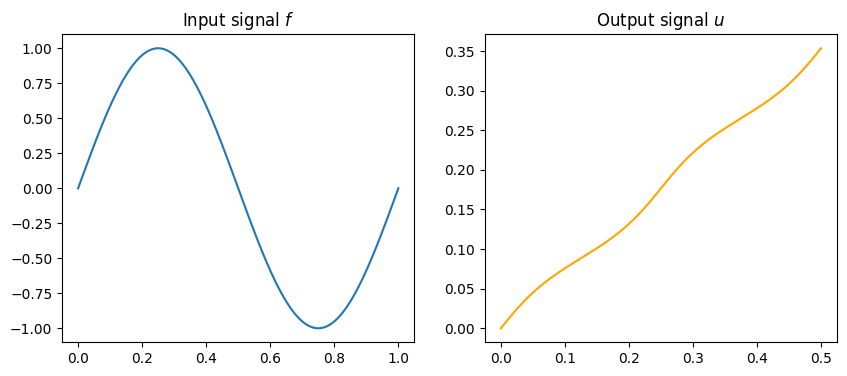

In [ ]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
yplot = np.linspace(0.0, 1.0, 1000)
plt.plot(yplot, f(yplot))
plt.title("Input signal $f$")

plt.subplot(1, 2, 2)
xplot = np.linspace(0.0, 0.5, 1000)
plt.plot(xplot, [u(x) for x in xplot], color = 'orange')
plt.title("Output signal $u$")
None

In this case, evaluating the operator is not too expensive, so we can build our own dataset on-the-fly.

In order to sample a collection of possible "input signals" we shall use an auxiliary Gaussian process $Z:[0,1]\to\mathbb{R}$ whose realizations are of the form

$$Z(y)=\sum_{j=1}^{100}e^{-j} \eta_j \sin(\pi j y),$$

with $\eta_1,\dots,\eta_{100}$ i.i.d. $\mathcal{N}(0,1)$.

In [ ]:
def Z():
  eta = np.random.randn(100)
  j = np.arange(1, 101)
  c = eta*np.exp(-j)
  return lambda y: c @ np.sin(np.pi * j.reshape(-1, 1) * np.array(y).reshape(1, -1))

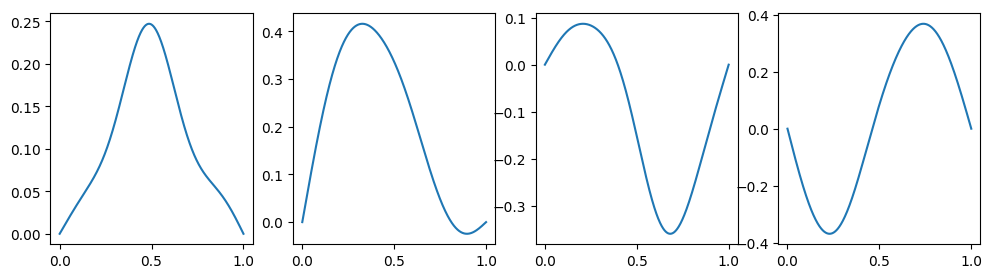

In [ ]:
plt.figure(figsize = (12, 3))
for k in range(4):
  plt.subplot(1, 4, k+1)
  f = Z()
  plt.plot(yplot, f(yplot))

In [ ]:
ndata = 200
xgrid = np.linspace(0, 0.5, 1000)
ysens = np.linspace(0, 1, 50)

mu = []
u = []

for n in range(ndata):
  clc(wait=True)
  print("Computing sample #%d..." % (n+1))

  np.random.seed(n)
  f = Z()
  mu_new = f(ysens)
  u_new = np.array([G(f)(x) for x in xgrid])

  mu.append(mu_new)
  u.append(u_new)

clc()

mu = np.stack(mu, axis = 0)
u = np.stack(u, axis = 0)

In [ ]:
mu, u, x = dv.tensor(mu, u, xgrid.reshape(-1, 1))

In [ ]:
p, d = mu.shape[1], x.shape[1]
m = 15

branch = Dense(p, 40) + Dense(40, 40) + Dense(40, m, activation = None)
trunk  = Dense(d, 40) + Dense(40, 40) + Dense(40, m, activation = None)

model = DeepONetX(branch, trunk, x)
model.He()

In [ ]:
branch.dof(), trunk.dof()

(4295, 2335)

In [ ]:
model.train(mu, u, epochs = 100, ntrain = 150, nvalid = 50, loss = loss, error = error, notation = '%')

		Train	Valid	Test
Epoch 100:	1.18%	1.84%	1.85%.

>> ETA: 0.05s.

Training complete. Elapsed time: 4.74 seconds.


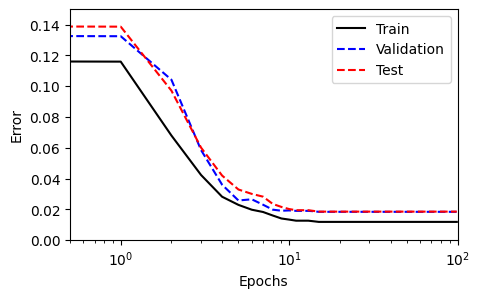

In [ ]:
n_epochs = len(model.errors['Train'])
plt.figure(figsize = (5, 3))
plt.semilogx(model.errors['Train'], '-k', label = 'Train')
plt.semilogx(model.errors['Validation'], '--b', label = 'Validation')
plt.semilogx(model.errors['Test'], '--r', label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.axis([0.5, n_epochs, 0, 0.15])
plt.legend()
plt.show()

In [ ]:
model.freeze()

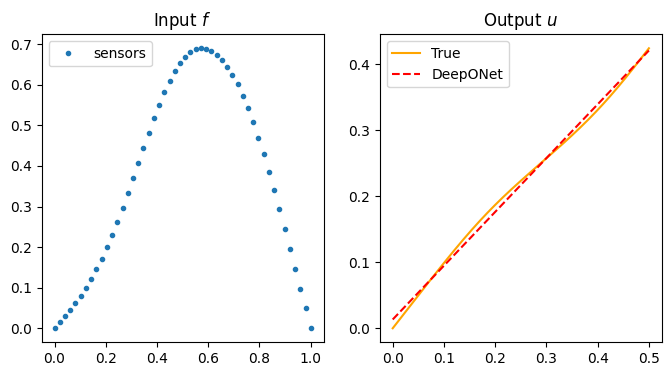

In [ ]:
j = -7
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
yplot = np.linspace(0.0, 1.0, 1000)
plt.plot(ysens, mu[j], '.', label = 'sensors')
plt.title("Input $f$")
plt.legend()

plt.subplot(1, 2, 2)
xplot = np.linspace(0.0, 0.5, 1000)
plt.plot(xgrid, u[j], color = 'orange', label = 'True')
plt.plot(xgrid, model(mu[j]), '--r', label = 'DeepONet')
plt.title("Output $u$")
plt.legend()
None